In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# The Grid World

We have seen in class that we can obtain value function using [FittedValueIteration](https://deepnote.com/project/Ch-7-Dynamic-Programming-Um_5m_ESQkebC8UvD4jWzg/%2Fdp.ipynb). 

## Linear Programming for Dynamic Programming

For our discrete grid world, let's try to obtain the optimal cost-to-go using [linear programming](https://underactuated.csail.mit.edu/dp.html#LP). Linear Programming is an optimization program with linear objective functions as well as linear equality and inequality constraints. If you are not familiar with optimization, you could take a look at the linear programming [tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/linear_program.ipynb) in Drake. The following cells are setting up the grid world and the transition matrix $T$ in eq(14) in the textbook.

In [2]:
xbins = range(0, 21)
ybins = range(0, 21)
[X, Y] = np.meshgrid(xbins, ybins)
states = np.vstack((X.reshape(441), Y.reshape(441)))

[ux, uy] = np.meshgrid([-1, 0, 1], [-1, 0, 1])
inputs = np.vstack((ux.reshape(9), uy.reshape(9)))

goal = [2, 8]

def obstacle(x):
    return x[0]>=6 and x[0]<=8 and x[1]>=4 and x[1]<=7

A = np.eye(2)
B = np.eye(2)

input_dim = inputs.shape[1]
state_dim = states.shape[1]

T = np.zeros([state_dim, state_dim, input_dim])

for i in range(input_dim):
    for j in range(state_dim):
        next_state = A @ states[:, j] + B @ inputs[:, i]
        ind = np.argmin(np.linalg.norm(states.T - next_state, axis=1))
        T[j, ind, i] = 1

In [3]:
    def min_time_cost(x, u):
        state_cost = 1
        if obstacle(x):
            state_cost = 10
        if np.array_equal(x, goal):
            state_cost = 0
        action_cost = np.linalg.norm(u, 1)
        if action_cost > 1:
            action_cost = 10
        return state_cost + action_cost

Now it's your turn to code up the linear program for solving the optimal cost-to-go. These Drake [tutorials](https://github.com/RobotLocomotion/drake/tree/master/tutorials) could be super helpful for setting up the optimization program. To deal with numerical instability, you should use a discount factor $\gamma$ for the Bellman update: $$ J \leq l(a) + \gamma T(a) J, \quad \forall a.$$

In [4]:
a = np.array([1,2,3,4])
sum(a[[1,2,3]])

9

In [5]:
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
import numpy as np

# Create an empty MathematicalProgram named prog (with no decision variables,
# constraints or costs)
prog = MathematicalProgram()
J = prog.NewContinuousVariables(state_dim, "J")

gamma = 0.99999

for i in range(input_dim):
    l = np.zeros(state_dim)
    for j in range(state_dim):
        ## Calculate
        l[j] = min_time_cost(states[:, j], inputs[:, i]) # modify here
        ## Modify here
        ## Add Constraint for each entry of J
        ind = np.where(T[j,:,i] == 1)[0]  # next states
        if np.any(ind) == True:
            prog.AddLinearConstraint(J[j] - gamma*sum(J[ind])/len(ind) <= l[j])
        # prog.AddBoundingBoxConstraint(0, np.inf, J[j])

## Modify here
## Add cost to prog
prog.AddLinearCost(-sum(J))

result = Solve(prog)
J_value = np.reshape(result.GetSolution(J), X.shape)

Let's visualize the value function you calculated using LP. It should be similiar to the plot obtained from FittedValueIteration.

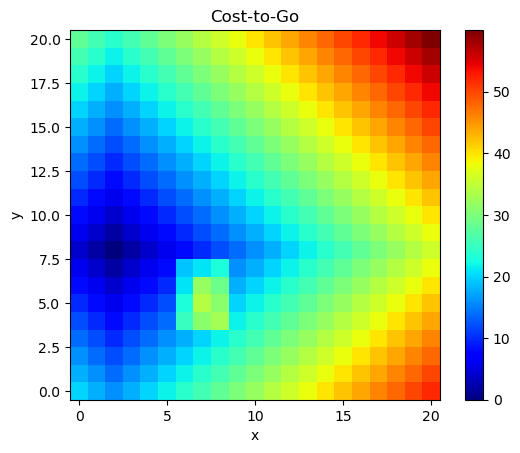

In [6]:
(fig, ax) = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Cost-to-Go")
k = ax.imshow(J_value, cmap=cm.jet)
ax.invert_yaxis()
plt.colorbar(k)
plt.show()

## Autograding
You can check your work by running the following cell:

In [7]:
from underactuated.exercises.dp.test_lp_dp import Testlpdp
from underactuated.exercises.grader import Grader
Grader.grade_output([Testlpdp], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 8/8.

Score for Test optimal cost-to-go from Linear Program is 8/8.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0590fe85-77b4-4272-a10a-d226e580f5de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>